In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [104]:
import warnings
warnings.filterwarnings('ignore')

In [105]:
data = pd.read_csv('fer2013.csv') #Reading the FER2013 dataset

In [106]:
# data = data[data['emotion']!=1]

In [107]:
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort = False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)

emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Disgust,547


Text(0.5, 0, 'Emotional Status')

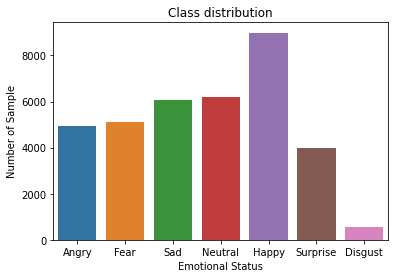

In [108]:
plt.figure()
# print('\n')
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number of Sample')
plt.xlabel('Emotional Status')

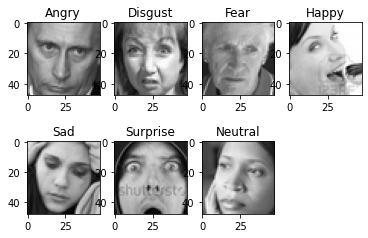

In [109]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48, 48)
    image = np.zeros((48, 48, 3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure()
for i in [0, 1, 2, 3, 4, 5, 6]:
    face = data[data['emotion'] == i].iloc[9]
    img = row2image(face)
    #   print('\n')
    plt.subplot(2, 4, i+1)
    plt.imshow(img[0])
    plt.title(img[1])
    #print(' ')


In [110]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()

print(data_train.shape, data_val.shape, data_test.shape)

(28709, 3) (3589, 3) (3589, 3)


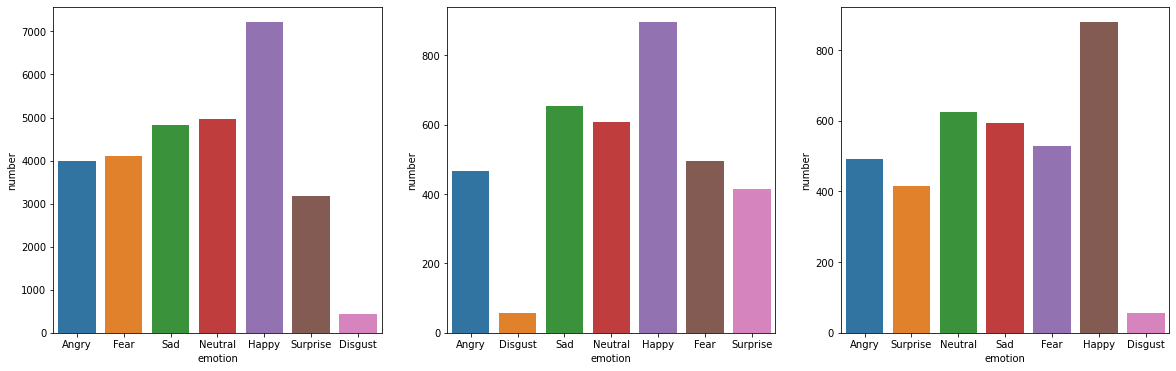

In [111]:
plt.figure(0, figsize = (20, 6))

train_emotion_counts = data_train['emotion'].value_counts(sort = False).reset_index()
train_emotion_counts.columns = ['emotion', 'number']
train_emotion_counts['emotion'] = train_emotion_counts['emotion'].map(emotion_map)
plt.subplot(1, 3, 1)
sns.barplot(train_emotion_counts.emotion, train_emotion_counts.number)

val_emotion_counts = data_val['emotion'].value_counts(sort = False).reset_index()
val_emotion_counts.columns = ['emotion', 'number']
val_emotion_counts['emotion'] = val_emotion_counts['emotion'].map(emotion_map)
plt.subplot(1, 3, 2)
sns.barplot(val_emotion_counts.emotion, val_emotion_counts.number)

test_emotion_counts = data_test['emotion'].value_counts(sort = False).reset_index()
test_emotion_counts.columns = ['emotion', 'number']
test_emotion_counts['emotion'] = test_emotion_counts['emotion'].map(emotion_map)
plt.subplot(1, 3, 3)
sns.barplot(test_emotion_counts.emotion, test_emotion_counts.number)

plt.show()

In [112]:
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [113]:
def CRNO(df):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    #pixel_sequence = df['pixels']
    #df['pixels'] = [int(pixel) for pixel in pixel_sequence.split()]
    data_X = np.array(df['pixels'].tolist(), dtype = 'float32').reshape(-1, width, height, 1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    return data_X, data_Y

In [114]:
train_X, train_Y = CRNO(data_train)
val_X, val_Y = CRNO(data_val)
test_X, test_Y = CRNO(data_test)

In [115]:
# oversample = BorderlineSMOTE()
# train_X, train_Y = oversample.fit_resample(train_X, train_Y)

In [116]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding = 'same', input_shape=((width, height, 1)), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 48, 48, 256)       2560      
_________________________________________________________________
batch_normalization_27 (Batc (None, 48, 48, 256)       1024      
_________________________________________________________________
activation_27 (Activation)   (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 256)       590080    
_________________________________________________________________
batch_normalization_28 (Batc (None, 48, 48, 256)       1024      
_________________________________________________________________
activation_28 (Activation)   (None, 48, 48, 256)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 256)      

In [117]:
data_generator = ImageDataGenerator(featurewise_center = False,
                                    featurewise_std_normalization = False,
                                    rotation_range = 20,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range = 0.1,
                                    horizontal_flip = True)

es = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
# es = EarlyStopping(monitor = 'val_accuracy', patience = 30, mode = 'max', restore_best_weights = True)

history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                    steps_per_epoch = len(train_X) / batch_size,
                    epochs = num_epochs,
                    verbose = 1, 
                    callbacks = [es],
                    validation_data = (val_X, val_Y))
# model.save('/content/drive/My Drive/Colab Notebooks/Data/FacialEmotion/trainmodel2.hdf5')

Epoch 1/50
448/448 [==============================] - 48s 73ms/step - loss: 1.8853 - accuracy: 0.2354 - val_loss: 1.8381 - val_accuracy: 0.2494
Epoch 2/50
448/448 [==============================] - 33s 73ms/step - loss: 1.7564 - accuracy: 0.2770 - val_loss: 2.3020 - val_accuracy: 0.1995
Epoch 3/50
448/448 [==============================] - 33s 73ms/step - loss: 1.5623 - accuracy: 0.3849 - val_loss: 2.2050 - val_accuracy: 0.2680
Epoch 4/50
448/448 [==============================] - 33s 73ms/step - loss: 1.3886 - accuracy: 0.4643 - val_loss: 1.3365 - val_accuracy: 0.4879
Epoch 5/50
448/448 [==============================] - 33s 73ms/step - loss: 1.3068 - accuracy: 0.5004 - val_loss: 1.3985 - val_accuracy: 0.4592
Epoch 6/50
448/448 [==============================] - 33s 73ms/step - loss: 1.2476 - accuracy: 0.5237 - val_loss: 1.4244 - val_accuracy: 0.4831
Epoch 7/50
448/448 [==============================] - 33s 73ms/step - loss: 1.2071 - accuracy: 0.5396 - val_loss: 1.3500 - val_accuracy:

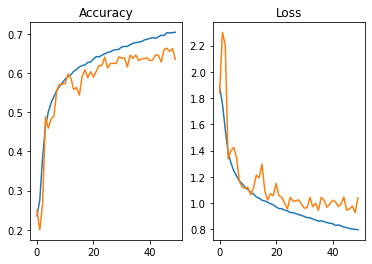

In [118]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Accuracy')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Loss')

plt.show()

In [119]:
model.evaluate(val_X, val_Y, verbose=1)

113/113 [==============================] - 1s 13ms/step - loss: 1.0398 - accuracy: 0.6347


[1.0398435592651367, 0.6347171664237976]

In [120]:
model.evaluate(test_X, test_Y, verbose=1)

113/113 [==============================] - 1s 13ms/step - loss: 0.9952 - accuracy: 0.6425


[0.9952208399772644, 0.6425188183784485]

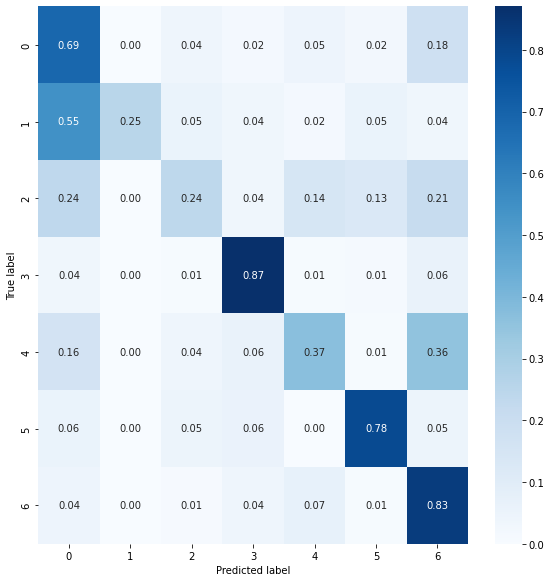

In [121]:
pred_Y=model.predict(test_X)

tesst_Y=np.argmax(test_Y, axis=1)
pred_Y=np.argmax(pred_Y,axis=1)

cmatrix=confusion_matrix(tesst_Y, pred_Y)
cmatrix = cmatrix.astype('float')/cmatrix.sum(axis=1)[:, np.newaxis]

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True, fmt= '.2f', cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [122]:
print(classification_report(tesst_Y, pred_Y))

              precision    recall  f1-score   support

           0       0.50      0.69      0.58       491
           1       1.00      0.25      0.41        55
           2       0.61      0.24      0.35       528
           3       0.87      0.87      0.87       879
           4       0.59      0.37      0.45       594
           5       0.75      0.78      0.77       416
           6       0.51      0.83      0.63       626

    accuracy                           0.64      3589
   macro avg       0.69      0.58      0.58      3589
weighted avg       0.66      0.64      0.62      3589

